# Capstone Project
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Recap](#recap)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Recap <a name="recap"></a>

In [1]:
from IPython.display import IFrame
IFrame("./capstone.pdf", width=800, height=500)

## Methodology <a name="methodology"></a>

In this project I will be detecting areas in Hanoi that have residents actively engaging in healthy activities, particularly places with presences of fitness centers/parks. We will also be looking at places with shopping malls or educational institutions because it has been researched that youngsters like to explore new types of drinks.

In first step I will collect the required **data: location and type (category) of popular venues within 6km from a district's center**. I will also **identify names of venues** (according to Foursquare categorization).

Second step in the analysis will be exploring of '**top categories**' across different districts of Hanoi - we will use **bar graphs** to identify a few promising districts and focus our attention on those areas.

In third and final step I will focus on most promising areas and create **clusters of locations that meet some basic requirements** established in discussion with stakeholders. I will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

First, I will have to import some of the necessary libraries for the exploration:
* **numpy** : array and matrices computing  
* **pandas**: data manipulation and analysis
* **bs4**: web scrapping
* **geopy**: getting exact locations
* **folium**: map visualisation
* **matplotlib**: graph plotting
* **sklearn**: algorithms

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests
import json
from pandas.io.json import json_normalize

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

Next, I will use BeautifulSoup to extract the table that contains all the districts from the wikipedia page into a pandas Dataframe.

In [3]:
url = 'https://en.wikipedia.org/wiki/Hanoi'
request = requests.get(url)
soup = BeautifulSoup(request.content, 'html.parser')
# print(soup.prettify())

Creating a loop to find the table that contains all the details of the districts in Hanoi.

In [4]:
tables = soup.find_all('table', class_="wikitable")

def find_table(tables):
    testStr = "Subdivisions of Hanoi"
    for table in tables:
        th_elem = table.find('th').text
        
        if th_elem.find(testStr) != -1:
            return table
    return None
        

required_table = find_table(tables)
# print(required_table.prettify())

Get the urban districts only!

In [5]:
table_contents = []
counter = 0

for row in required_table.findAll('tr'):
    if counter < 3:
        counter += 1
        continue
        
    if counter >= 15:
        break
    cell = {}
    cell['District'] = row.a.text;
    cell['Wards'] = row.findNext('td').findNext('td').text;
    cell['Area'] = row.findNext('td').findNext('td').findNext('td').text;
    cell['Population'] = row.findNext('td').findNext('td').findNext('td').findNext('td').text.strip('\n');
    
    table_contents.append(cell)
    counter += 1  

df = pd.DataFrame(table_contents)
df 

,District,Wards,Area,Population
0,Ba Đình,14,9.21,"221,893"
1,Bắc Từ Liêm,13,45.32,"335,110"
2,Cầu Giấy,8,12.32,"292,536"
3,Đống Đa,21,9.95,"371,606"
4,Hai Bà Trưng,20,10.26,"303,586"
5,Hà Đông,17,49.64,"397,854"
6,Hoàn Kiếm,18,5.29,"135,618"
7,Hoàng Mai,14,40.32,"506,347"
8,Long Biên,14,59.82,"322,549"
9,Nam Từ Liêm,10,32.19,"264,246"


In [6]:
df.shape

(12, 4)

Assign coordinations to each district

In [7]:
from geopy.geocoders import Nominatim

latitude = []
longitude = []

for district_name in df['District']:
    address=district_name
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    print(address)
    print(location.latitude, location.longitude)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

df = df.assign(**{'Latitude' : latitude, 'Longitude' : longitude})

Ba Đình
21.0340746 105.8145271
Bắc Từ Liêm
21.0698605 105.7573392
Cầu Giấy
21.02916475 105.80343767219591
Đống Đa
32.0575279 118.78682252043946
Hai Bà Trưng
21.0059701 105.8574845
Hà Đông
35.0900603 118.3972545
Hoàn Kiếm
21.0285237 105.8507155
Hoàng Mai
19.2562655 105.7105509
Long Biên
21.03988935 105.85009190185264
Nam Từ Liêm
21.0128458 105.7608745
Tây Hồ
30.2616958 120.1256628
Thanh Xuân
20.9936873 105.8143014


In [8]:
df

,District,Wards,Area,Population,Latitude,Longitude
0,Ba Đình,14,9.21,"221,893",21.034075,105.814527
1,Bắc Từ Liêm,13,45.32,"335,110",21.069861,105.757339
2,Cầu Giấy,8,12.32,"292,536",21.029165,105.803438
3,Đống Đa,21,9.95,"371,606",32.057528,118.786823
4,Hai Bà Trưng,20,10.26,"303,586",21.005970,105.857484
5,Hà Đông,17,49.64,"397,854",35.090060,118.397255
6,Hoàn Kiếm,18,5.29,"135,618",21.028524,105.850716
7,Hoàng Mai,14,40.32,"506,347",19.256266,105.710551
8,Long Biên,14,59.82,"322,549",21.039889,105.850092
9,Nam Từ Liêm,10,32.19,"264,246",21.012846,105.760874


In [9]:
address = 'Hanoi'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
hanoi_latitude = location.latitude
hanoi_longitude = location.longitude
print('The geograpical coordinate of Hanoi are {}, {}.'.format(hanoi_latitude, hanoi_longitude))

The geograpical coordinate of Hanoi are 21.0294498, 105.8544441.


Create the map of Hanoi

In [10]:
map_hanoi = folium.Map(location = [hanoi_latitude, hanoi_longitude], zoom_start = 10)


for lat, lng, district in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html = True)
    print(district,lat,lng)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.9,
        parse_html = True).add_to(map_hanoi)

    
map_hanoi

Ba Đình 21.0340746 105.8145271
Bắc Từ Liêm 21.0698605 105.7573392
Cầu Giấy 21.02916475 105.80343767219591
Đống Đa 32.0575279 118.78682252043946
Hai Bà Trưng 21.0059701 105.8574845
Hà Đông 35.0900603 118.3972545
Hoàn Kiếm 21.0285237 105.8507155
Hoàng Mai 19.2562655 105.7105509
Long Biên 21.03988935 105.85009190185264
Nam Từ Liêm 21.0128458 105.7608745
Tây Hồ 30.2616958 120.1256628
Thanh Xuân 20.9936873 105.8143014


In [11]:
CLIENT_ID = 'HW2CX1YZ2VHVP0ZOXJH0MAMSGSAOFUVMVEZNTC5D1JFKNZNR' 
CLIENT_SECRET = 'E3URJTEI00TUT4RRINYPCSKFOFRMTO02XU4MD4V5BTBMQ10O' 
ACCESS_TOKEN = 'VFTFUSQPNMGP0ZUF5JC0BYCGPRANSYGQWKVZP0P5OZXEPRLW'
VERSION = '20180604'
LIMIT = 10000

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=60000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('-----------------')
        print('District Name:',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

-----------------
District Name: Ba Đình
-----------------
District Name: Bắc Từ Liêm
-----------------
District Name: Cầu Giấy
-----------------
District Name: Đống Đa
-----------------
District Name: Hai Bà Trưng
-----------------
District Name: Hà Đông
-----------------
District Name: Hoàn Kiếm
-----------------
District Name: Hoàng Mai
-----------------
District Name: Long Biên
-----------------
District Name: Nam Từ Liêm
-----------------
District Name: Tây Hồ
-----------------
District Name: Thanh Xuân


In [14]:
print(venues.shape)
venues

(970, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Đình,21.034075,105.814527,Pepe la Poule,21.055677,105.821286,French Restaurant
1,Ba Đình,21.034075,105.814527,Standing Bar,21.046964,105.840201,Beer Bar
2,Ba Đình,21.034075,105.814527,Pizza 4P,21.034181,105.812777,Pizza Place
3,Ba Đình,21.034075,105.814527,Sofitel Legend Metropole Hanoi,21.025986,105.855687,Hotel
4,Ba Đình,21.034075,105.814527,Hotel La Siesta Trendy,21.032244,105.845727,Hotel
5,Ba Đình,21.034075,105.814527,La Siesta Hotel,21.034275,105.853351,Hotel
6,Ba Đình,21.034075,105.814527,Pizza 4Ps Lotte Hanoi,21.032145,105.813378,Pizza Place
7,Ba Đình,21.034075,105.814527,割烹 㐂六(キロク),21.027993,105.810130,Japanese Restaurant
8,Ba Đình,21.034075,105.814527,Pizza 4P,21.025141,105.854438,Italian Restaurant
9,Ba Đình,21.034075,105.814527,Công Viên Cầu Giấy (Yên Hoà),21.029339,105.789912,Park


In this step, I will collect data about venues where people engage in healthy activities

In [15]:
suitable_cat = ['Park', 'Climbing Gym', 'Gym / Fitness Center', 'Stadium', 'Golf Course']

venues.loc[1, 'Venue Category']

for r in range(970):
    if venues.loc[r, 'Venue Category'] not in suitable_cat:
        venues.loc[r, 'Venue Category'] = "NA"
        
venues = venues[venues['Venue Category'] != "NA"]

Starting from here, I will do an extensive clustering to find districts with common patterns

In [16]:
venues.groupby(['District','Venue Category']).count()

District Latitude  District Longitude  \
District     Venue Category                                                
Ba Đình      Climbing Gym                          1                   1   
             Golf Course                           5                   5   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Bắc Từ Liêm  Climbing Gym                          1                   1   
             Golf Course                           5                   5   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Cầu Giấy     Climbing Gym                          1                   1   
             Golf Course                           4                   4   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Hai Bà Trưng Climbing Gym                          1                   1   
             Golf Course                           5                   5   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Hoàn Kiếm    Climbing Gym                          1                   1   
             Golf Course                           5                   5   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Long Biên    Climbing Gym                          1                   1   
             Golf Course                           5                   5   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Nam Từ Liêm  Climbing Gym                          1                   1   
             Golf Course                           4                   4   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Thanh Xuân   Climbing Gym                          1                   1   
             Golf Course                           4                   4   
             Gym / Fitness Center                  1                   1   
             Park                                  3                   3   
             Stadium                               1                   1   
Tây Hồ       Park                                  2                   2   
Đống Đa      Park                                  4                   4   

                                   Venue  Venue Latitude  Venue Longitude  
District     Venue Category                                                
Ba Đình      Climbing Gym              1               1                1  
             Golf Course               5               5                5  
             Gym / Fitness Center      1               1                1  
             Park                      3               3                3  
             Stadium                   1               1                1  
Bắc Từ Liêm  Climbing Gym              1               1                1  
             Golf Course               5               5                5  
      

<AxesSubplot:xlabel='District'>

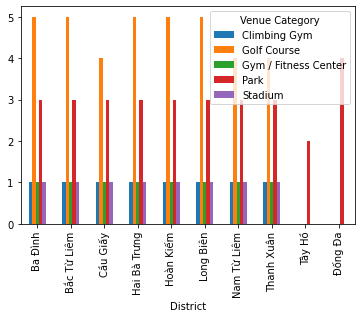

In [17]:
venues.groupby(['District'])['Venue Category'].value_counts().unstack().plot.bar()

In [18]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 5 uniques categories.


In [19]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['District'] = venues['District'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
grouped = onehot.groupby('District').mean().reset_index()
grouped.head()

,District,Climbing Gym,Golf Course,Gym / Fitness Center,Park,Stadium
0,Ba Đình,0.090909,0.454545,0.090909,0.272727,0.090909
1,Bắc Từ Liêm,0.090909,0.454545,0.090909,0.272727,0.090909
2,Cầu Giấy,0.100000,0.400000,0.100000,0.300000,0.100000
3,Hai Bà Trưng,0.090909,0.454545,0.090909,0.272727,0.090909
4,Hoàn Kiếm,0.090909,0.454545,0.090909,0.272727,0.090909


In [20]:
num_top_venues = 5

for district in grouped['District']:
    print("----"+district+"----")
    temp = grouped[grouped['District'] == district].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ba Đình----
                  venue  freq
0           Golf Course  0.45
1                  Park  0.27
2          Climbing Gym  0.09
3  Gym / Fitness Center  0.09
4               Stadium  0.09


----Bắc Từ Liêm----
                  venue  freq
0           Golf Course  0.45
1                  Park  0.27
2          Climbing Gym  0.09
3  Gym / Fitness Center  0.09
4               Stadium  0.09


----Cầu Giấy----
                  venue  freq
0           Golf Course   0.4
1                  Park   0.3
2          Climbing Gym   0.1
3  Gym / Fitness Center   0.1
4               Stadium   0.1


----Hai Bà Trưng----
                  venue  freq
0           Golf Course  0.45
1                  Park  0.27
2          Climbing Gym  0.09
3  Gym / Fitness Center  0.09
4               Stadium  0.09


----Hoàn Kiếm----
                  venue  freq
0           Golf Course  0.45
1                  Park  0.27
2          Climbing Gym  0.09
3  Gym / Fitness Center  0.09
4               Stadium  0.09


In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['District'] = grouped['District']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ba Đình,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
1,Bắc Từ Liêm,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
2,Cầu Giấy,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
3,Hai Bà Trưng,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
4,Hoàn Kiếm,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym


In [22]:
kclusters = 3

grouped_clustering = grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 2, 2, 1, 1])

In [23]:
# add clustering labels
venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

merged = df

# merge to add latitude/longitude for each district
merged = merged.join(venues_sorted.set_index('District'), on='District')

merged = merged.dropna()


merged.head() # check the last columns!

,District,Wards,Area,Population,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ba Đình,14,9.21,"221,893",21.034075,105.814527,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
1,Bắc Từ Liêm,13,45.32,"335,110",21.069861,105.757339,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
2,Cầu Giấy,8,12.32,"292,536",21.029165,105.803438,2.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
3,Đống Đa,21,9.95,"371,606",32.057528,118.786823,1.0,Park,Stadium,Gym / Fitness Center,Golf Course,Climbing Gym
4,Hai Bà Trưng,20,10.26,"303,586",21.005970,105.857484,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym


In [24]:
# create map
map_clusters = folium.Map(location=[hanoi_latitude, hanoi_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'],merged['Longitude'], merged['District'], merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster) - 1],
        fill=True,
        fill_color=rainbow[int(cluster) - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results <a name="results"></a>

### Cluster 1

In [25]:
merged.loc[merged['ClusterLabels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]].head()

,Wards,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,14,105.814527,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
1,13,105.757339,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
4,20,105.857484,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
6,18,105.850716,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
8,14,105.850092,0.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym


### Cluster 2

In [26]:
merged.loc[merged['ClusterLabels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]].head()

,Wards,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,21,118.786823,1.0,Park,Stadium,Gym / Fitness Center,Golf Course,Climbing Gym
10,8,120.125663,1.0,Park,Stadium,Gym / Fitness Center,Golf Course,Climbing Gym


### Cluster 3

In [27]:
merged.loc[merged['ClusterLabels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]].head()

,Wards,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,8,105.803438,2.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
9,10,105.760874,2.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym
11,11,105.814301,2.0,Golf Course,Park,Stadium,Gym / Fitness Center,Climbing Gym


## Discussion <a name="discussion"></a>

Based on the results obtained, it can be seen that districts that belong to cluster 2 usually have residents frequented at fitness centers. Thus, these districts will be suitable to open a healthy drink stores as it is believed people need some refreshing drinks before and after exercise.These drinks will provide them with adequate nutritions and help them to recharge. It is hope that residents after conducting their workouts would pick healthy drinks instead of non-healthy alternatives such as bubble tea or softdrinks that might cause health disease in the long term.

However, when doing the analysis, I faced some difficulties that my visualisation may not substantially portray what is needed:
* Foursquare API does not provide the correct coordinates to plot the districts exactly on the map
* Foursquare API does not have sufficient information about all types of venues in Hanoi as some venues' info might not be publicly available


## Conclusion

The goal presented is achieved: owners can pick either cluster 2 to set up the store. This project is just one example of fantastic data science uses cases one can realize applying technology which is available for free today!